In [1]:
import os
os.chdir('../../')

In [2]:
cd = os.getcwd()
functions_path = os.path.join(cd, '02_code/functions')

In [3]:
#import required packages

import scanpy as sc
import scanpy.external as sce
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix

import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

# from scipy.sparse import csr_matrix
import sys
sys.path.append(functions_path)
import functions_dat_processing as dp

/tmp/ipykernel_1753914/1030767214.py:18: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [4]:
#import required R packages
soupx = ro.packages.importr('SoupX') 
scran = ro.packages.importr('scran') 
bcp = ro.packages.importr('BiocParallel') 
scry = ro.packages.importr('scry')


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [64]:
import importlib
importlib.reload(dp)

<module 'functions_dat_processing' from '/home/s377963/car_t_sc/02_code/functions/functions_dat_processing.py'>

In [5]:
path_to_folders = './01_data/raw/cellranger_multi'
path_to_count_matrices_in_folders = 'per_sample_outs/count/sample_filtered_feature_bc_matrix'
path_to_raw_count_matrices_in_folders = 'count/raw_feature_bc_matrix'

adatas = dp.read_all_pools(path_to_folders, path_to_count_matrices_in_folders)
adatas_raw = dp.read_all_pools(path_to_folders, path_to_raw_count_matrices_in_folders)

Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P1_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P2_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P3_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P4_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P5_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P6_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P7_cellranger/per_sample_outs/count/sample_filtered_feature_bc_matrix
Reading from: ./01_data/raw/cellra

In [61]:
adatas_mad = dp.quality_control(adatas)
# adatas_qntl = dp.quality_control(adatas, method = 'qntl')
# adatas_abs = dp.quality_control(adatas, method = 'abs')

computing qc for Pool 1
computing qc for Pool 2
computing qc for Pool 3
computing qc for Pool 4
computing qc for Pool 5
computing qc for Pool 6
computing qc for Pool 7
computing qc for Pool 8
computing qc for Pool 9
computing qc for Pool 1
computing qc for Pool 2
computing qc for Pool 3
computing qc for Pool 4
computing qc for Pool 5
computing qc for Pool 6
computing qc for Pool 7
computing qc for Pool 8
computing qc for Pool 9


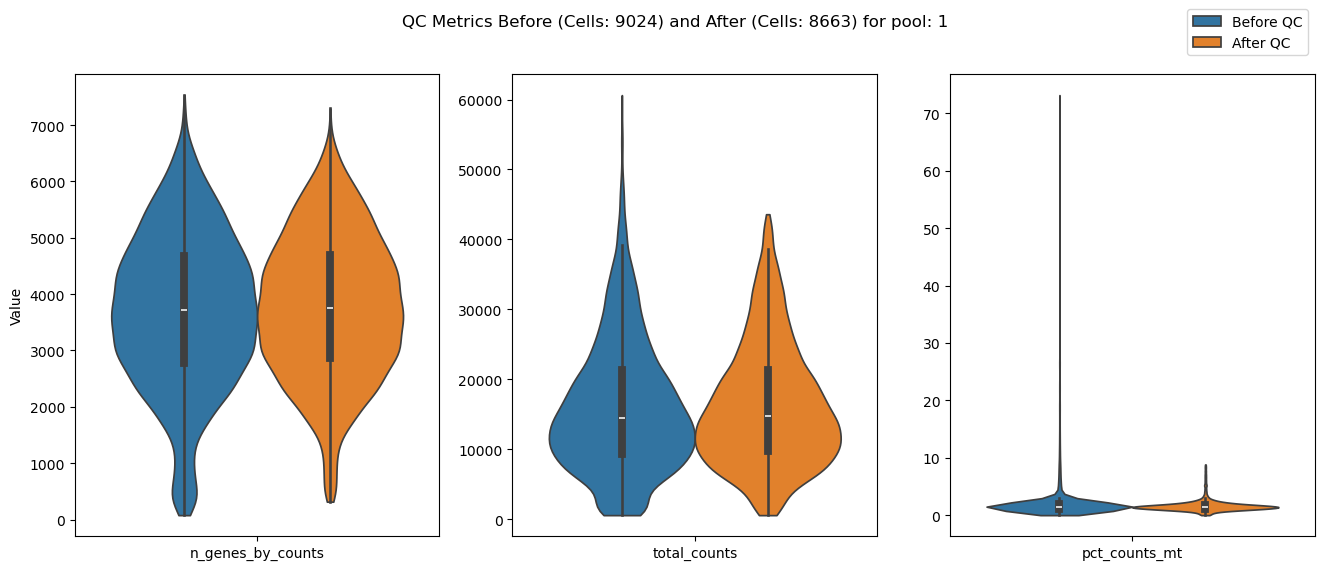

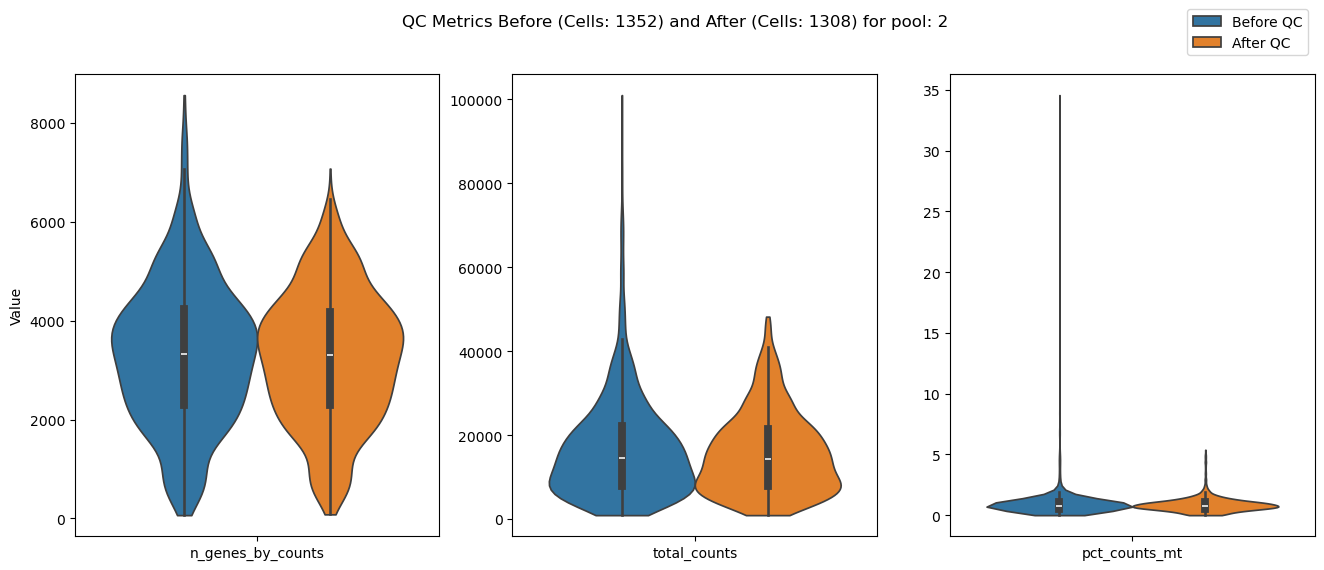

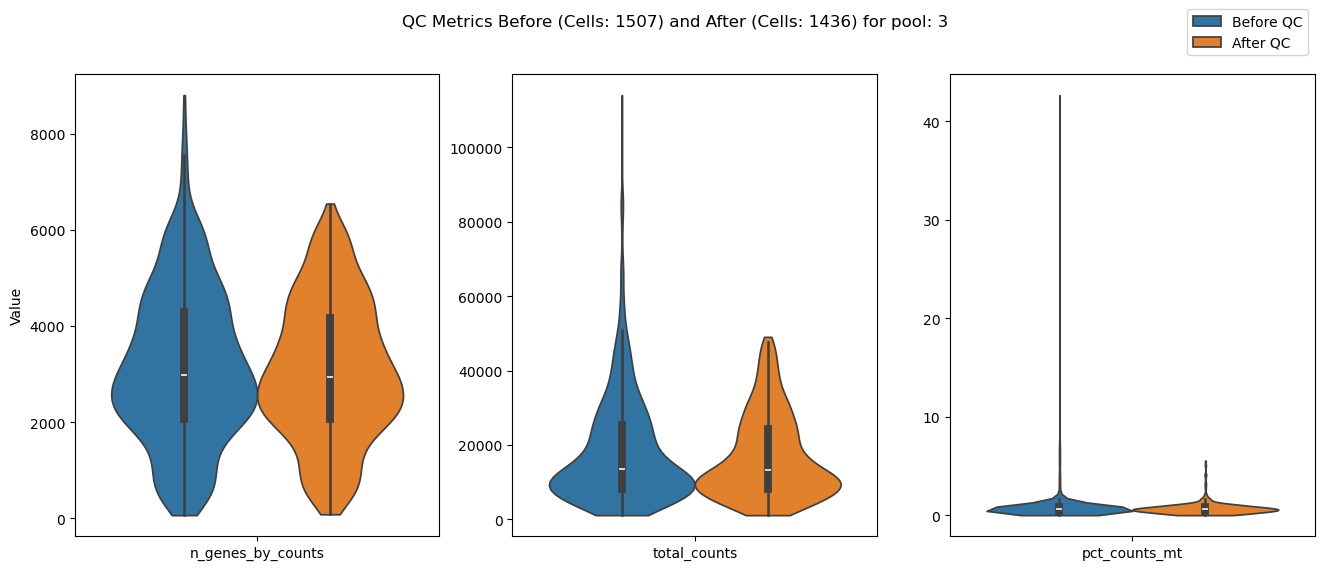

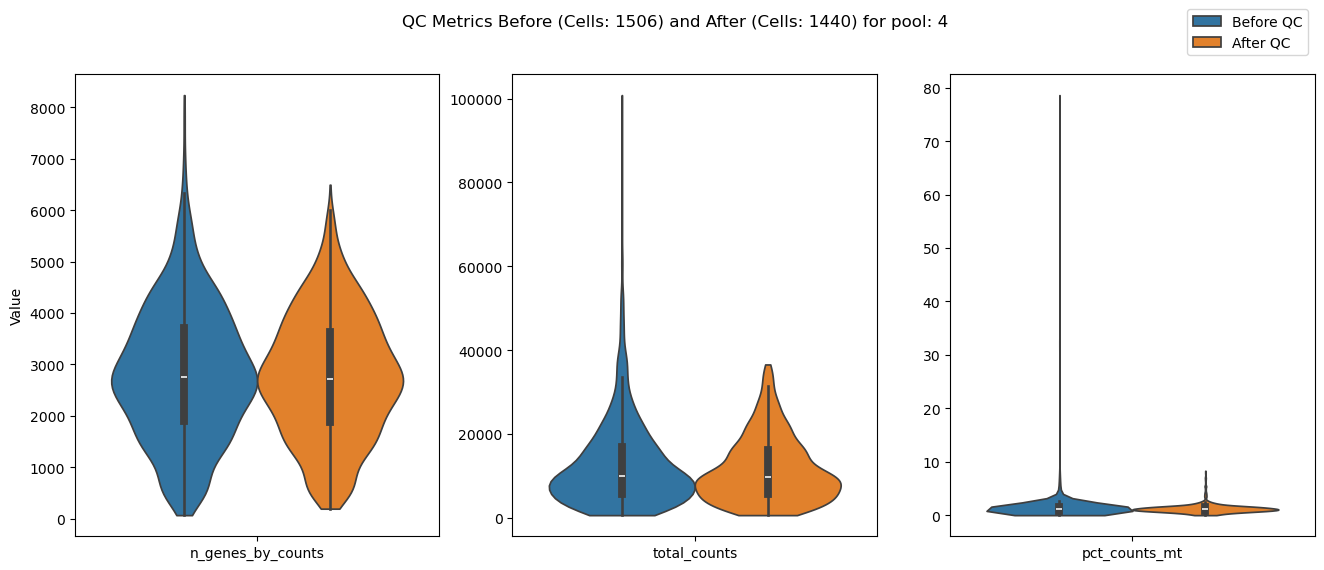

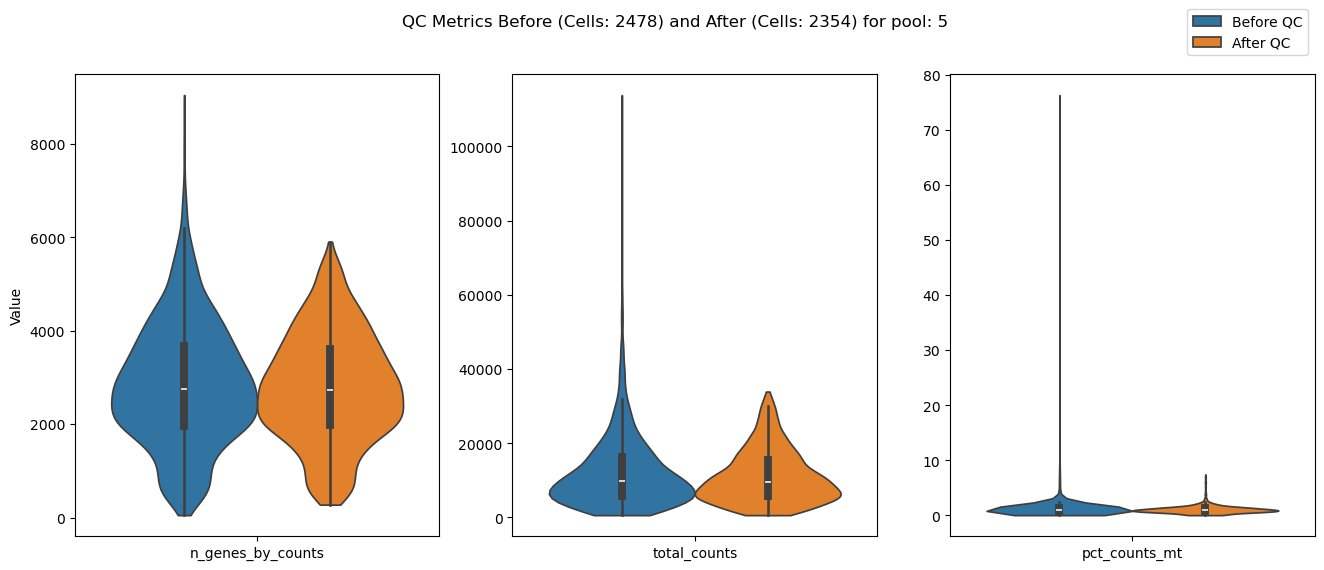

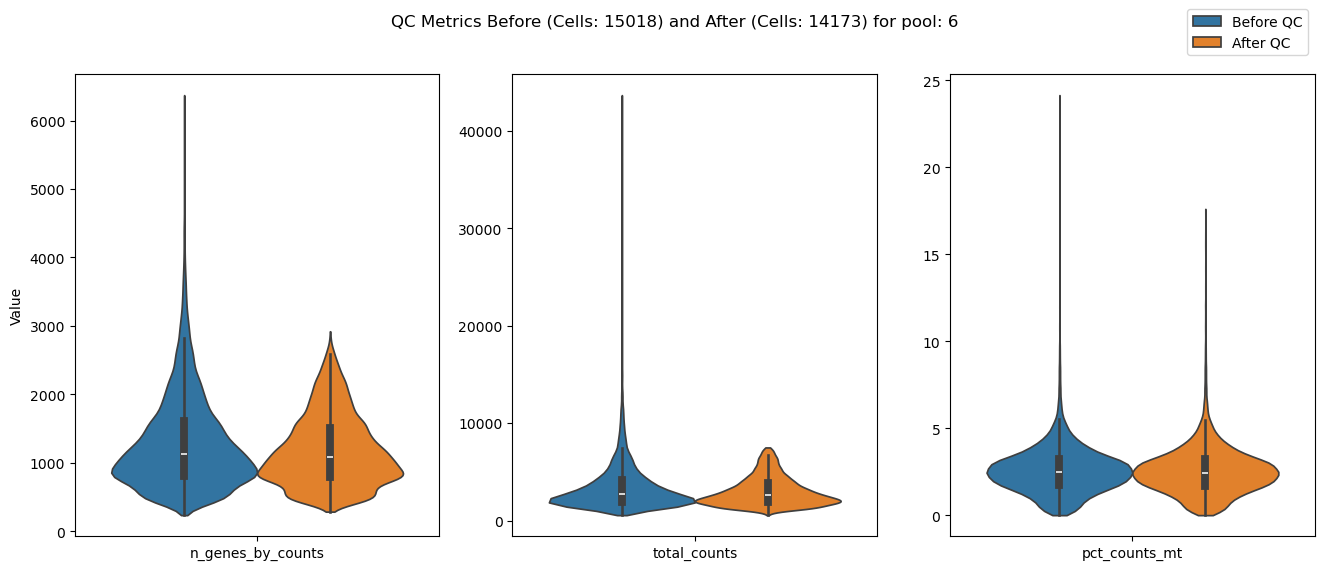

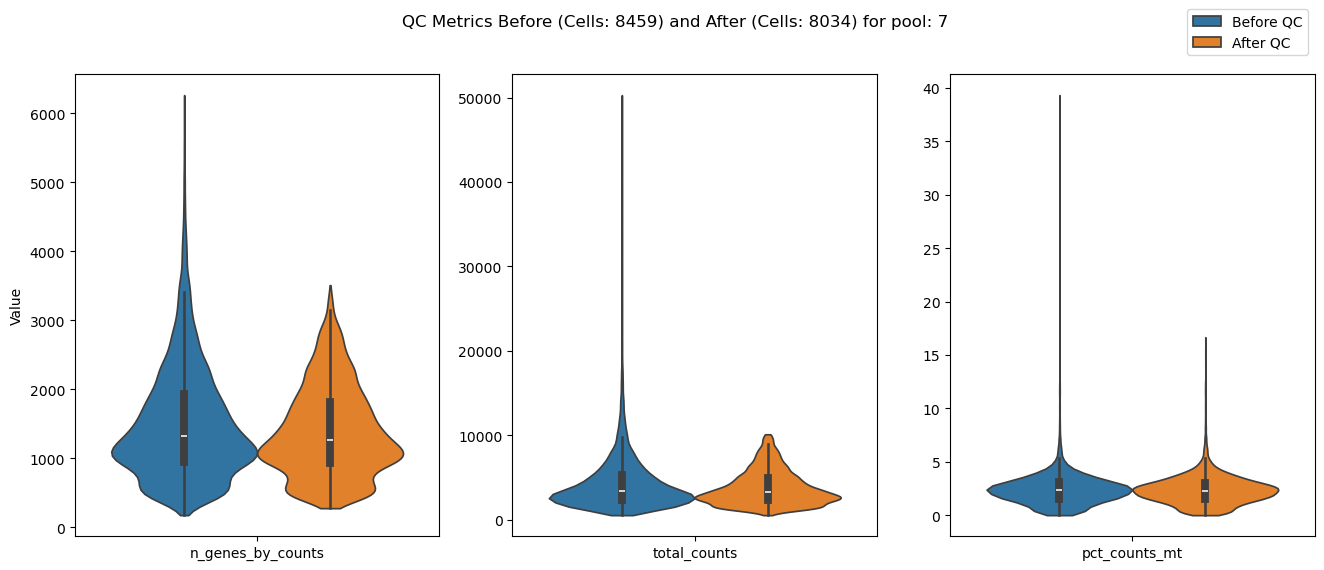

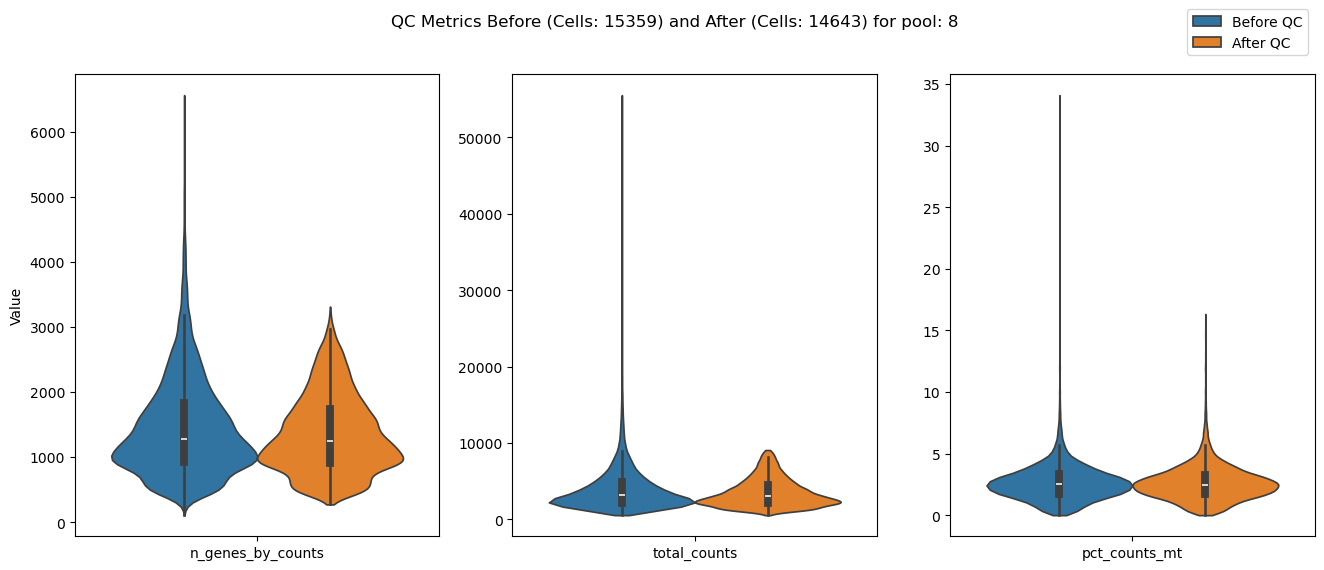

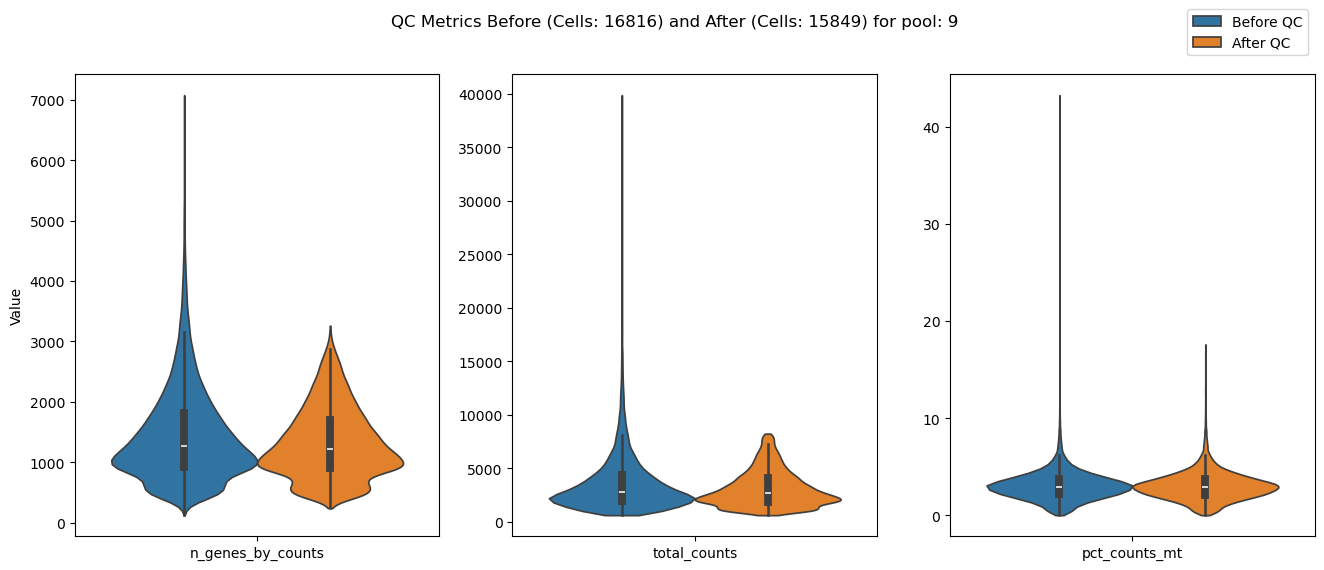

In [65]:
dp.plot_qc_metrics(adatas, adatas_mad)